# Pancancer analysis of all event types

#### Libraries

In [1]:
library(dplyr)
library(ggVennDiagram)
library(ggplot2)
library(ggsci)
library(fgsea)
library(ComplexHeatmap)
library(matrixStats)
library(ggpubr)
library(msigdbr)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




#### Parameters

In [6]:
# Analysis type

#analysis<-"tumorStageContinuous"
#voi<-"stage"
analysis<-"condition"
voi<-"conditiontumor"
p.signif.event<-0.05

# Event information
out_obj_dir<-"../../../chapter2_Methods/2.4_FunctionalAnalysisASevents/input/trex_objects"
flags_dir<-"../../../chapter2_Methods/2.4_FunctionalAnalysisASevents/output/psi_flags"

events_used<-c("SE","A3","A5","MX","RI","AF","AL")
cancer_order_set<-c("SKCM","UVM","SARC","LAML","TGCT","UCEC","CESC","PRAD","READ","BLCA",
                "COAD","PAAD","CHOL","KIRP","KIRC","KICH","ACC","PCPG","STAD","LIHC",
                "MESO","LUSC","LUAD","BRCA","THCA","ESCA","HNSC")
# Internal
fig_dir<-paste0("../output/figures/event_stats")
vars<-c(voi,"impurity")
res.file<-paste0(out_obj_dir,"/tcga.",analysis,".res.lfcShrink.RDS")
dir.create(fig_dir, showWarnings = FALSE)
set.seed(7)

#### Load data

In [3]:
trex.res.lfsh<-readRDS(file = res.file) %>%
               filter(event_type %in% events_used)

In [4]:
flags<-lapply(unique(trex.res.lfsh$cancer),function(can){
            d<-list.files(flags_dir,pattern=paste(can,"*"),full.names=T) %>%
                lapply(.,function(fl,...){
                    d<-data.table::fread(fl,data.table=F) %>%
                        mutate(event_type=sub("_psi.*","",basename(fl)) %>% sub(".*_","",.),
                              cancer=can) 
                    return(d)
                }) %>%
            do.call(rbind,.)
        }) %>% 
        do.call(rbind,.) %>%
        filter(event_type%in%events_used) 

#### Number of events quantified in different number of cancers

In [7]:
trex.res.fg<-left_join(trex.res.lfsh,flags)
trex.res.sig<-trex.res.fg %>%
              filter(exp_var==voi) %>%
              filter(event_flag=="valid") %>%
              mutate(significant=padj<p.signif.event)

Joining, by = c("event_type", "cancer", "event_id")


In [8]:
sevs<-trex.res.sig %>%
      filter(significant) %>%
      distinct(event_id)

ev.sum<-trex.res.sig %>%
        filter(event_id %in% sevs$event_id) %>%
        group_by(event_type,gene_id,event_id) %>%
        summarize(ncancers=length(unique(cancer)),
                  ncancers_signif=length(unique(cancer[significant]))) %>%
        arrange(desc(ncancers)) %>%
        mutate(event_type=factor(event_type,levels=events_used))

totals<-trex.res.sig %>%
        group_by(event_type) %>%
        filter(event_id %in% sevs$event_id) %>%
        summarize(nevents=length(unique(event_id)))

`summarise()` has grouped output by 'event_type', 'gene_id'. You can override
using the `.groups` argument.


## Summary visualizations
---

#### Distribution of PSI fllags

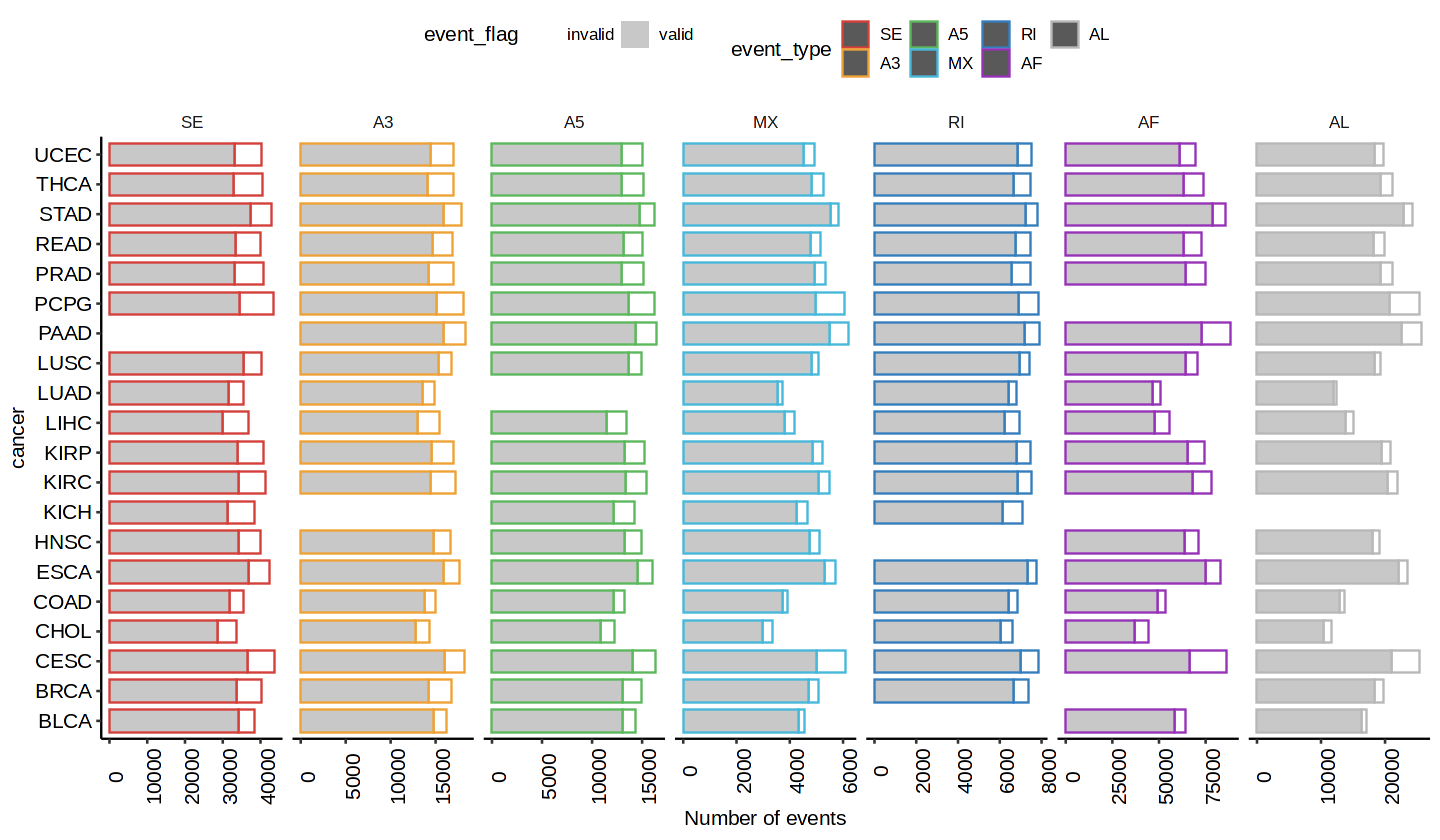

In [9]:
options(repr.plot.width=12,repr.plot.height=7)
p<-flags %>%
    mutate(event_type=factor(event_type,levels=events_used)) %>%
    ggplot(.,aes(y=cancer,color=event_type,fill=event_flag))+
        geom_bar(stat="count",width = 0.75,linewidth=0.5)+
        theme_pubr()+
        facet_wrap(~event_type,scale="free_x",ncol=7)+
        theme(strip.background=element_blank(),
              axis.text.x = element_text(angle=90,hjust=0.5))+
        scale_color_locuszoom()+
        scale_fill_manual(values=c("#FFFFFF","#C9C8C8"))+
        labs(x="Number of events")
ggsave(p,filename=paste0(fig_dir,"/psi.flag.summaries.pdf"),width=12,height=7,device = "pdf")
p

#### Number of quantified events

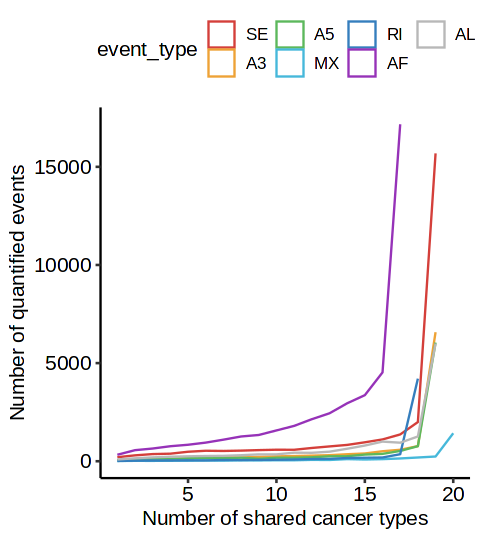

In [10]:
options(repr.plot.width=4,repr.plot.height=4.5)
p<-ev.sum %>%
    ggplot(.,aes(ncancers,color=event_type))+
        geom_density(stat="count")+
        theme_pubr()+
        theme(strip.background=element_blank(),
              legend.position="top")+
        scale_color_locuszoom()+
        labs(x="Number of shared cancer types",y="Number of quantified events")
ggsave(p,filename=paste0(fig_dir,"/quantified.event.distribution.allcancers.pdf"),width=4,height=4.5,device = "pdf")
p

#### Number of shared events

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


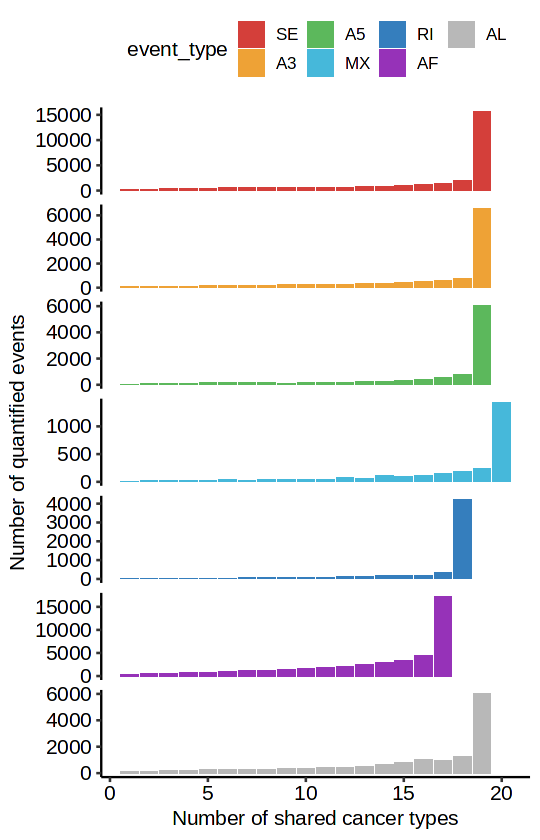

In [11]:
options(repr.plot.width=4.5,repr.plot.height=7)
p<-ev.sum %>%
    ggplot(.,aes(ncancers,fill=event_type))+
        geom_histogram(stat="count")+
        theme_pubr()+
        facet_wrap(~event_type,scales="free_y",ncol=1)+
        theme(strip.background=element_blank(),
              strip.text=element_blank(),
              legend.position="top")+
        scale_fill_locuszoom()+
        labs(x="Number of shared cancer types",y="Number of quantified events")
ggsave(p,filename=paste0(fig_dir,"/quantified.event.distribution.allcancers.byEventType.pdf"),width=4.5,height=7,device = "pdf")
p

#### Proportion of significant events in more than different number of cancers

`summarise()` has grouped output by 'ncancers_signif'. You can override using
the `.groups` argument.
Joining, by = "event_type"


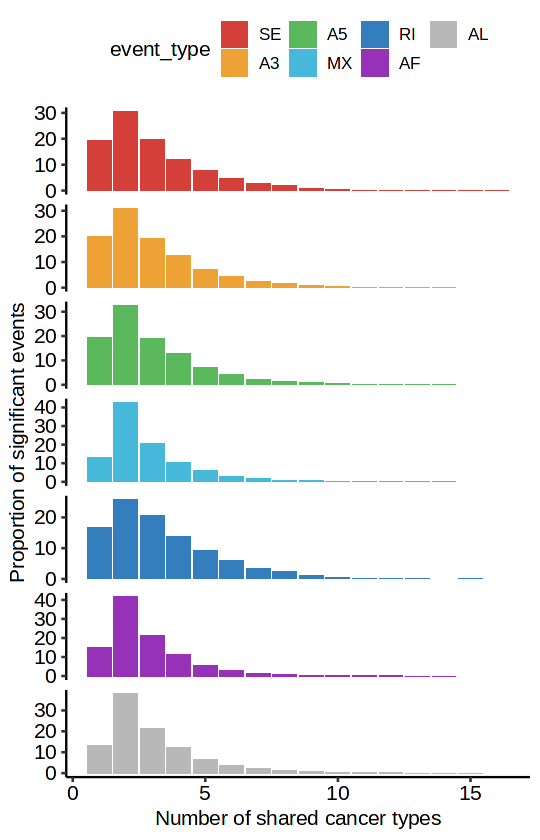

In [12]:
options(repr.plot.width=4.5,repr.plot.height=7)

ev.sum.p <- ev.sum %>%
            group_by(ncancers_signif,event_type)%>%
            summarize(nsevents=length(event_id)) %>%
            left_join(.,totals) %>%
            mutate(ps=nsevents/nevents*100,
                   event_type=factor(event_type,levels=events_used))
p<-ev.sum.p%>%
    ggplot(.,aes(x=ncancers_signif,y=ps,fill=event_type))+
        geom_bar(stat="identity")+
        theme_pubr()+
        theme(strip.background=element_blank(),
              strip.text=element_blank(),
              legend.position="top")+
        scale_fill_locuszoom()+
        facet_wrap(~event_type,scale="free_y",ncol=1)+
        labs(x="Number of shared cancer types",y="Proportion of significant events")

ggsave(p,filename=paste0(fig_dir,"/significant.event.counts.allcancers.byEventType.pdf"),width=4.5,height=7,device = "pdf")
p

In [13]:
ev.sum.p <- ev.sum %>%
            ungroup() %>%
            filter(ncancers_signif!=0) %>%
            group_by(ncancers_signif,event_type)%>%
            summarize(nsevents=length(unique(event_id))) %>%
            left_join(.,totals) %>%
            mutate(ps=nsevents/nevents*100,
                   event_type=factor(event_type,levels=events_used))

`summarise()` has grouped output by 'ncancers_signif'. You can override using
the `.groups` argument.
Joining, by = "event_type"


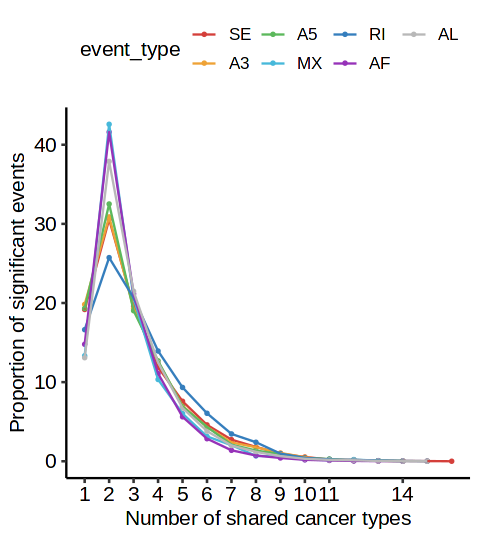

In [14]:
options(repr.plot.width=4,repr.plot.height=4.5)
p<-ev.sum.p %>%
    ggplot(.,aes(x=ncancers_signif,y=ps,color=event_type))+
        geom_point(size=0.5)+
        geom_line(linewidth=0.5)+
        theme_pubr()+
        theme(strip.background=element_blank(),
              legend.position="top",
              axis.text.y = element_text(size=12))+
        scale_color_locuszoom()+
        labs(x="Number of shared cancer types",y="Proportion of significant events")+
        scale_x_continuous(breaks = c(1:10,11,14))
ggsave(p,filename=paste0(fig_dir,"/significant.event.distribution.allcancers.pdf"),width=4,height=4.5,device = "pdf")
p